# Ciencia de Datos - Trabajo Final
Autor: Miguel Ángel Medina Ramírez

El objetivo de este proyecto es encontrar el mejor clasificador para el conjunto de datos con el fin de obtener un modelo que nos permita distinguir de entre un conjuntos de pacientes a aquellos que puedan padecer de riesgo cardiaco, para ello se probarán diferentes transformaciones y modelos con el fin de obtener un buen estimador que nos garantice una buena relación entre falsos positivos y negativos.El conjunto de datos con el que se ha trabajado ha sido extraído de kaggle y se encuentra en el siguiente [enlace](https://www.kaggle.com/andrewmvd/heart-failure-clinical-data).


In [7]:
# Dependencias básicas
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, TransformerMixin

# Visualización de datos
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import plotly.express as px

# Transformación de datos
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn.feature_selection import RFE
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, Normalizer
from imblearn.over_sampling import SMOTE

# Modelos Sklearn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
# Keras
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
#from keras.wrappers.scikit_learn import KerasClassifier

# Métricas
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_validate
#from sklearn.metrics import plot_roc_curve, auc, roc_curve, roc_auc_score
#from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, plot_confusion_matrix


np.random.seed(1000) #se establece un valor por defecto para no variar los resultados de los clasificadores
data_dir = 'data' #Directorio de los datos

Las siguientes funciones presentan utilidades para la realización de varios aspectos del trabajo

In [8]:
def over_sampling(X: np.array, y: np.array) -> tuple:
  """
  Realiza un proceso de aumentación de datos con el algoritmo SMOTE
  """
  sm = SMOTE(random_state = 42)
  return sm.fit_resample(X, y)

def outlier(X: np.array) -> list:
  """
  Detecta las muestras consideradas como outlier
  """
  clf    = LocalOutlierFactor(n_neighbors=20)
  yhat   = clf.fit_predict(X)
  mask   = yhat != -1
  return mask

def TSNE_plot(data: pd.DataFrame):
  """
  Representa el conjunto de datos mediante el algoritmo T-SNE
  """
  X_embedded = TSNE(n_components=2).fit_transform(data)
  plt.scatter(X_embedded[:,0], X_embedded[:,1], c=data.DEATH_EVENT)
  plt.show()

def data_balance_plot(data: pd.DataFrame, categorical_features: list = []):
  """
  Representa los datos categoricos mediante un diagrama de barras para ver el equilibrio entre clases
  """
  i=0
  while i < len(categorical_features):
      fig = plt.figure(figsize=[8,3]) 

      plt.subplot(1,2,1)
      sns.countplot(x=categorical_features[i], data=data)
      i += 1
      
      plt.subplot(1,2,2)
      sns.countplot(x=categorical_features[i], data=data)
      i += 1
      
      plt.show()

def numerical_data_visualization(data: pd.DataFrame, categorical_features: list = []):
  """
  Visualiza mediante un diagrama de bigote los datos númericos del dataset
  """
  num_features = data.columns[~data.columns.isin(categorical_features)].tolist()
  r = c = 0
  fig,ax = plt.subplots(4,2,figsize=(15,14))

  for n,i in enumerate(num_features):
      sns.boxplot(x=i, data=data,ax=ax[r,c])
      c+=1
      if (n+1)%2==0:
          r+=1
          c=0
  ax[r,c].axis("off")
  plt.show()

def get_name_clf(clf):
    return clf.__class__.__name__

def neuronal_network(n_features: int):
    """
    Crea un red neuronal en keras para poder utilizarla en sklearn
    """
    clf = Sequential()
    clf.add(Dense(16, activation='relu', input_dim = n_features))
    clf.add(Dense(16, activation='relu'))
    clf.add(Dense(1, activation='sigmoid'))
    clf.compile(loss='binary_crossentropy', optimizer='adam', metrics=["accuracy"])
    clf._estimator_type = "binary_classifier"
    return clf

def print_measure(model: dict):
  print("%s\nAUC train k-flod: %.3f | AUC test: %.3f" %(model["name"],model["AUC_train"], model["AUC_test"]))

Los modelos con los que se va a experimentar son los siguientes:
 
* Regresión Logística
* Un red bayesiana
* KNN
* SVM con un kernel radial
* Árbol de decisión
* Bosque aleatorio
* AdaBoost
* Gradient tree boosting
* Tambíen se probaran el uso del deep learning mediante redes neuronales

Cada modelo irá acompañado de una serie de transformaciones y reducciones de dimensionalidad de los datos mediante diferentes algoritmos. Las transformaciones principales serán dos procesos de normalización muy extendidos:
 
* Standardscaler: z = (x - u) / s
* Normalización L2
 
Para la reducción de dimensionalidad se probaran los siguientes procedimientos variando el número de características que queremos tener:
 
* PCA
* Sequential Feature Selector
* Select K Best mediante Chi-cuadrado
* Clasificación de características con eliminación de características recursivas(RFE)
 
**Procedimiento**: se van a probar todas las combinaciones posibles entre modelo, normalización y reducción de la dimensionalidad haciendo uso de las *Pipeline* de sklearn. Al final del procedimiento se escogerá al mejor modelo y se realizará un ajuste de sus hiper-parámetros para obtener el mejor clasificador posible.


In [9]:
"""
Para la reducción de dimensionalidad se van a probar a reducir a 6 y a 10 las características de las 12 iniciales
"""
k1 = 6
k2 = 10

classifiers = [
  LogisticRegression(),
  GaussianNB(),
  KNeighborsClassifier(7),
  SVC(kernel="rbf", C=0.025, probability=True),
  DecisionTreeClassifier(),
  RandomForestClassifier(),
  AdaBoostClassifier(),
  GradientBoostingClassifier()
]

CLASSIFIERS = [(get_name_clf(clf), clf) for clf in classifiers]

NORMALIZATION = [
  ('StandardScaler', StandardScaler()),
  ('Normalizer', Normalizer())
]

FEATURE_EXTRACTION = [
  ('SFS k = %i' %k1, SequentialFeatureSelector(LogisticRegression(), k_features = k1)),
  ('SFS k = %i' %k2, SequentialFeatureSelector(LogisticRegression(), k_features = k2)),
  ('PCA k = %i' %k1, PCA(n_components = 2)),
  ('PCA k = %i' %k2, PCA(n_components = 6)),
  ('KBest - chi k = %i' %k1, SelectKBest(chi2, k=k1)),
  ('KBest - chi k = %i' %k2, SelectKBest(chi2, k=k2)),
  ('RFE k = %i' %k1, RFE(LogisticRegression(), n_features_to_select = k1)),
  ('RFE k = %i' %k2, RFE(LogisticRegression(), n_features_to_select = k2)),
]

## Exploración de datos (EDA)

En esta parte se van a conocer los datos con los que estamos trabajando.



In [10]:
data    = pd.read_csv('%s/heart_failure_clinical_records_dataset.csv' %(data_dir))
COLUMNS = data.keys()[:-1]
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  DEATH_EVENT               299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 30.5 KB


In [11]:
data.describe()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
count,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.00000,299.000000,299.000000,299.00000,299.000000,299.00000
mean,60.833893,0.431438,581.839465,0.418060,38.083612,0.351171,263358.029264,1.39388,136.625418,0.648829,0.32107,130.260870,0.32107
std,11.894809,0.496107,970.287881,0.494067,11.834841,0.478136,97804.236869,1.03451,4.412477,0.478136,0.46767,77.614208,0.46767
min,40.000000,0.000000,23.000000,0.000000,14.000000,0.000000,25100.000000,0.50000,113.000000,0.000000,0.00000,4.000000,0.00000
25%,51.000000,0.000000,116.500000,0.000000,30.000000,0.000000,212500.000000,0.90000,134.000000,0.000000,0.00000,73.000000,0.00000
50%,60.000000,0.000000,250.000000,0.000000,38.000000,0.000000,262000.000000,1.10000,137.000000,1.000000,0.00000,115.000000,0.00000
75%,70.000000,1.000000,582.000000,1.000000,45.000000,1.000000,303500.000000,1.40000,140.000000,1.000000,1.00000,203.000000,1.00000
max,95.000000,1.000000,7861.000000,1.000000,80.000000,1.000000,850000.000000,9.40000,148.000000,1.000000,1.00000,285.000000,1.00000


Como es natural en los datasets de **Kaggle** los datos están bastante limpios(sin valores perdidos) para ir directamente a la parte de los estimadores. Como disponemos de muy pocas muestras tenemos que utilizar validación cruzada para obtener un mejor rendimiento.


#### Datos categoricos

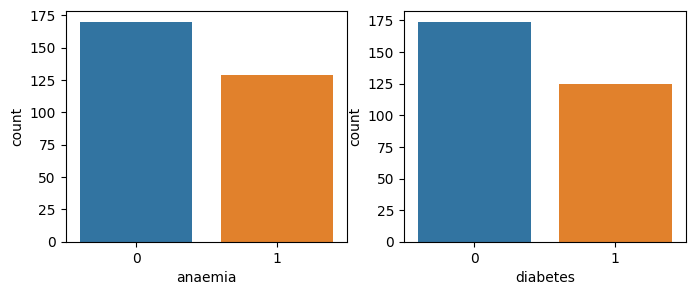

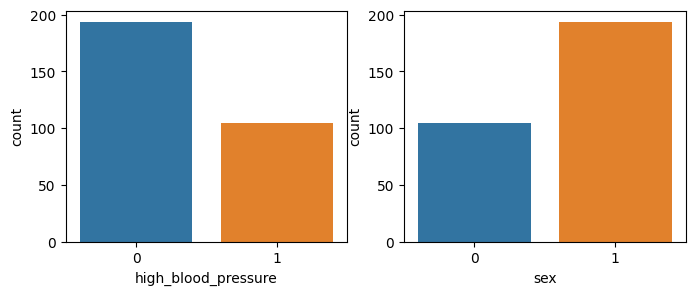

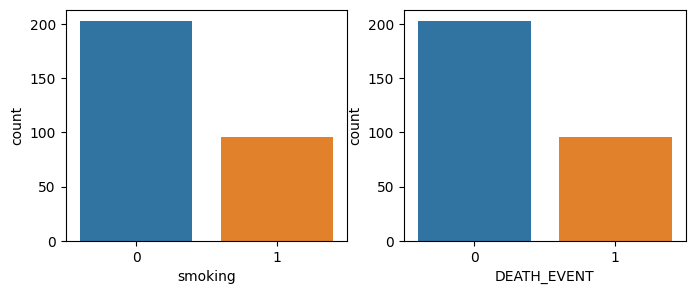

In [12]:
# Los datos categoricos son los siguientes
CATEGORICAL = ["anaemia","diabetes","high_blood_pressure","sex","smoking","DEATH_EVENT"]
data_balance_plot(data, CATEGORICAL)

Vemos que existe una gran dispariedad en el balanceado de los datos, y hay un gran efecto de algunas variables como el 'sexo' o la 'anemia' con respecto al valor de la clase.

#### Datos númericos

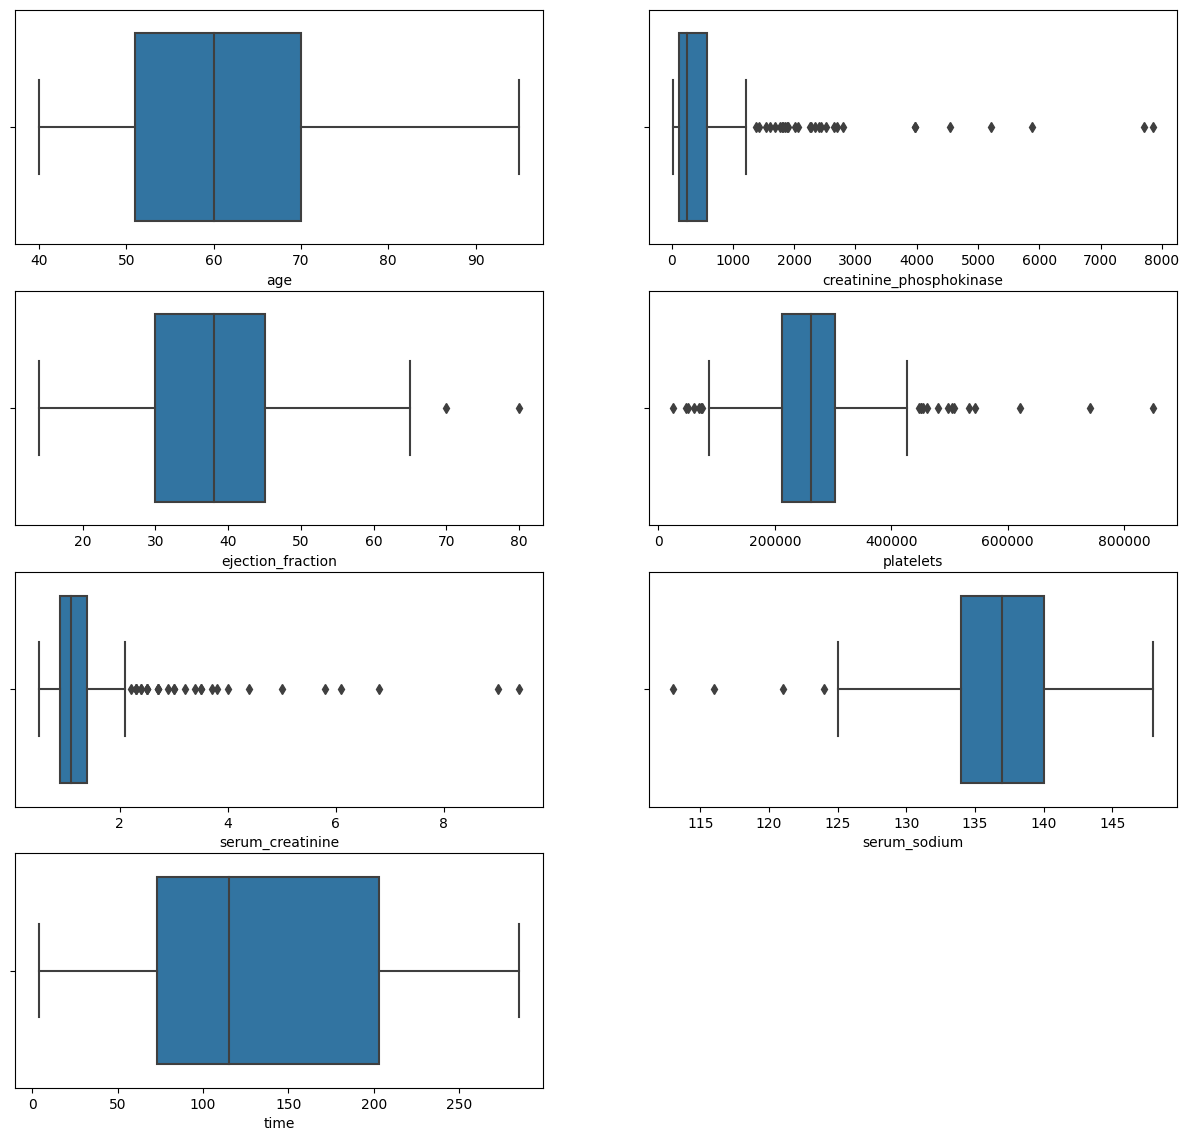

In [13]:
numerical_data_visualization(data, categorical_features=CATEGORICAL)

Como se puede observar en los diagramas de caja anteriores, 'creatinine_phosphokinase', 'platelets' y 'serum_creatinine' tienen valores atípicos que podrían afectar la toma de decisiones de nuestro modelo. Existen varias técnicas con las que se pueden tratar los valores atípicos, en este trabajo se usará la detección de outliers haciendo uso de modelos no supervisados mediante el factor de valores atípicos locales (LOF). 

### Correlación

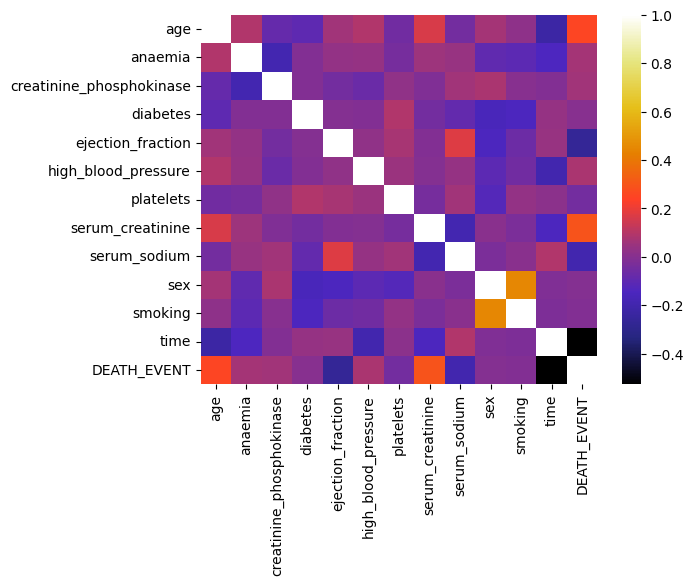

In [14]:
sns.heatmap(data.corr(), cmap="CMRmap")
plt.show()

Segun el mapa de correlaciones existen varibles que afectan considerablemente a la clase como la edad o la cantidad de 'serum creatinine', sin embargo existen otras como el hecho que el paciente fuera fumador o el sexo que no guardan mucha correlación. Además podemos ver que las características entre ellas no suelen presentarse una alta o baja correlación salvando algunas excepciones. En suma, podemos concluir que con una algoritmo de reducción de dimensiones se podría mejorar el rendimiento de los modelos empleados si se mantiene un número adecuado de columnas(entre 6 o 10 como se había planteado inicialmente).

### Visulazación de datos

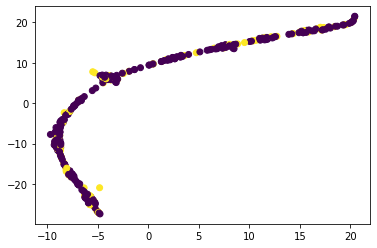

In [13]:
TSNE_plot(data)

Si representamos el conjunto de datos con un algoritmo TSNE en dos dimensiones podemos ver que se trata de un conjunto de muestras complicado de resolver para clasificadores lineales simples, debido a que no es posible una división adecuada de las muestras para estos algoritmos, sin embargo los métodos de ensemble basados en árboles deberían dar un buen rendimiento, de todas formas se probará con un alto número de modelos y transformaciones. Además se presentan una serie de puntos fuera de la distribución seguramente a causa de la presencia de algunos outliers.

### Preparación de datos

En esta parte se quitan los outliers del conjunto de datos inicial y se procede a hacer uso de un método de aumentación de datos usando el algoritmo SMOTE.

In [15]:
class dataset:

  def __init__(self, X: np.array, y: np.array, name: str = "", test_size: int = 15):
    if  not 0 < test_size < 100: 
      raise RuntimeError("Wrong percentage range")
    
    self.name = name
    self.X = X
    self.y = y
    
    self.X_train, self.X_test, self.y_train, self.y_test  = train_test_split(X, y, test_size = test_size/100)

  def split(self) -> tuple:
    return self.X_train, self.X_test, self.y_train, self.y_test

  def create_DataFrame(self) -> pd.DataFrame:
    frame = {
      col: values
      for col, values in zip(COLUMNS,self.X.transpose())
    }
    frame['DEATH_EVENT'] = self.y
    return pd.DataFrame(
      data = frame,
    )

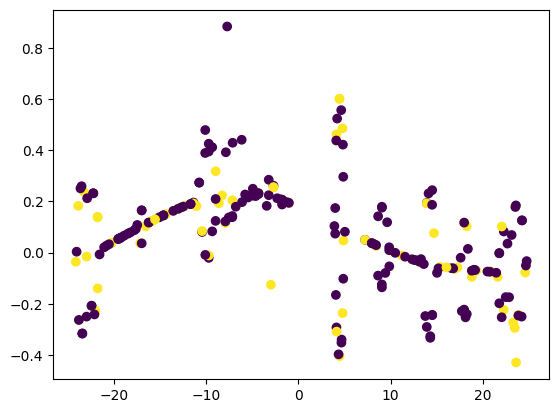

In [16]:
ds_base = dataset(data.values[:, :-1], data.values[:, -1], name = "basic")

mask: list = outlier(ds_base.X)
ds_without_outlier = dataset(ds_base.X[mask, :], ds_base.y[mask], name = "without outlier")
TSNE_plot(ds_without_outlier.create_DataFrame())

Como se puede apreciar el procedimiento a quitado un par de muestras que sobresalen de la distribución de muestras inicial, con lo cual obtenemos una distribución más limpia a cambio de perder un par de muestras.

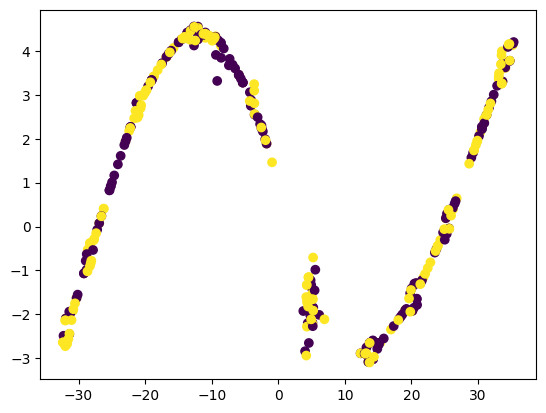

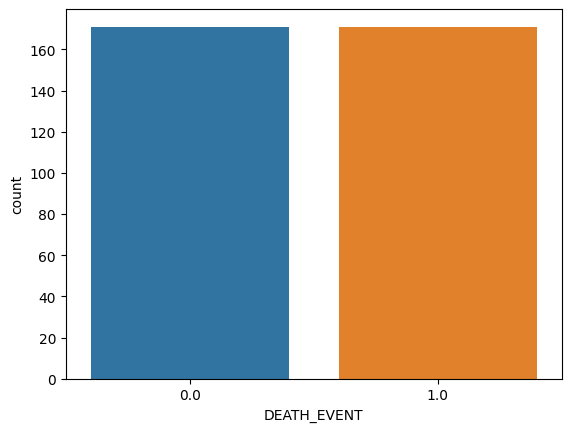

In [17]:
x_aux,y_aux = over_sampling(ds_without_outlier.X, ds_without_outlier.y)
ds_SMOTE = dataset(x_aux, y_aux, name = "SMOTE aumentation")
TSNE_plot(ds_SMOTE.create_DataFrame())
sns.countplot(x = 'DEATH_EVENT', data = ds_SMOTE.create_DataFrame())

DATASETS = [
    ds_base,
    ds_without_outlier,
    ds_SMOTE
]

Ahora el conjunto de datos está perfectamente equilibrado. Se usarán en las pruebas los tres datasets, para cada uno de ellos se van a probar todas las combinaciones posibles entres los algoritmos.

## Pruebas con Modelos

En esta parte se van a entrenar y valorar muchos modelos, como métrica se va a utilizar la curva ROC junto a la AUC debido a que los que estamos buscando es el mejor clasificador con la mejor relación posible entre falsos negativos y falsos positivos. De cada dataset preparado se van a escoger los tres mejores modelos en base a el rendimiento en el entrenamiento y en el test, para entrenar los modelos se va a utilizar la función *cross_validate* que implementa una validación cruzada k-flod estratificada, como hiper-parámetro se va a utilizar k = 5. Finalmente se representarán los mejores modelos con su matriz de confusión y su curva ROC sobre los datos de test. Aunque el procedimiento de validación cruzada con k-flod ya garantiza una división entre entrenamiento y test, para validar la efectiva de nuestros estimadores se ha utilizado un procedimiento similar a las competiciones de Kaggle en donde tenemos un conjunto de datos de pruebas finales por dataset para comprobar la efectividad de los modelos planteados, en este caso se ha utilizado el 15% de los datos para crear el conjunto de test.

In [18]:
class Model:

  def __init__(self, pipeline: Pipeline):
    self._pipeline = pipeline
    
    self.estimators        = []
    if isinstance(pipeline, Pipeline):
       self.name = " + ".join(pipeline.named_steps.keys())
    else:
      self.name = get_name_clf(pipeline)
    self.auc_measure_train = 0
    self.auc_measure_test  = 0

  def train(self, X_train: np.array, y_train: np.array, cv: int = 5) -> float:
    result = cross_validate(
        self._pipeline, 
        X_train, 
        y_train, 
        cv = cv,
        scoring=('roc_auc'),
        return_estimator = True
      )
    
    self.estimators        = result['estimator']
    self.auc_measure_train = np.mean(result['test_score'])

    return self.auc_measure_train                                       

  def evaluate(self, X_test: np.array,  y_test: np.array) -> float:

    conf_matrix_list_of_arrays = []
    for estimator in self.estimators:
      yhat = estimator.predict_proba(X_test)[:, 1]
      self.auc_measure_test += roc_auc_score(y_test, yhat)

      yhat = estimator.predict(X_test)
      conf_matrix = confusion_matrix(y_test, yhat)
      conf_matrix_list_of_arrays.append(conf_matrix)
    
    self.conf_matrix   = ConfusionMatrixDisplay(
      confusion_matrix = np.mean(conf_matrix_list_of_arrays, axis=0)
    )
    
    self.auc_measure_test /= len(self.estimators)
    return self.auc_measure_test

  def getMeasure(self) -> dict:
    return {
        "AUC_test": self.auc_measure_test,
        "AUC_train": self.auc_measure_train,
        "name": self.name,
        "estimators": self.estimators,
        "matrix": self.conf_matrix 
    }

In [19]:
class ModelsCollection:

  def __init__(self):
    self.collection = []

  def add(self, item):
     self.collection.append(item)

  def size(self) -> int:
    return len(self.collection)

  def get(self, index: int) -> Model:
    return self.collection[index]

  def chooseTheBest(self, number: int = 3):
    self.collection.sort(
      key = lambda x: x["AUC_test"] + x["AUC_train"],
      reverse = True
    )
    return self.collection[0:number]


In [20]:
class ModelsBuilder:

  def _rules(self, t0, t1) -> bool:
    return not (("KBest" in t0) and t1 == "StandardScaler")

  def __init__(self):

    self.combinations = []
    self.networks     = []

    self.combinations = [[clf] for clf in CLASSIFIERS]

    self.combinations[len(self.combinations):] = [
      list(reversed([clf, norm])) 
      for clf in CLASSIFIERS 
      for norm in NORMALIZATION]

    self.combinations[len(self.combinations):] = [
      list(reversed([clf, fe])) 
      for clf in CLASSIFIERS 
      for fe in FEATURE_EXTRACTION]

    self.combinations[len(self.combinations):] = [
      list(reversed([clf, norm, fe]))
      for clf in CLASSIFIERS 
      for norm in NORMALIZATION 
      for fe in FEATURE_EXTRACTION
      if self._rules(fe[0], norm[0])
    ]

    # Aproximación conexionista

    epochs     = 100
    batch_size = 16
    self.networks = [
      [("NN",KerasClassifier(neuronal_network, n_features=12, epochs=epochs, batch_size=batch_size, verbose=0))],
      [
        ('Normalizer', Normalizer()),
        ('KBest - chi k = %i' %k2, SelectKBest(chi2, k=k2)),
        ("NN",KerasClassifier(neuronal_network, n_features=k2, epochs=epochs, batch_size=batch_size, verbose=0))
      ],
      [
        ('Normalizer', Normalizer()),
        ('KBest - chi k = %i' %k2, SelectKBest(chi2, k=k2)),
        ("NN",KerasClassifier(neuronal_network, n_features=k2, epochs=epochs, batch_size=batch_size, verbose=0))
      ],
      [
        ('Normalizer', Normalizer()),
        ("NN",KerasClassifier(neuronal_network, n_features=12, epochs=epochs, batch_size=batch_size, verbose=0))
      ],
      [
        ('StandardScaler', StandardScaler()),
        ("NN",KerasClassifier(neuronal_network, n_features=12, epochs=epochs, batch_size=batch_size, verbose=0))
      ],
      [
        ('Normalizer', Normalizer()),
        ('PCA k = %i' %k2, PCA(n_components = k2)),
        ("NN",KerasClassifier(neuronal_network, n_features=k2, epochs=epochs, batch_size=batch_size, verbose=0))
      ]
    ]


  def buildClassifiers(self, deep_learning: bool = False):
    pipeline = self.networks if deep_learning else self.combinations
    for pipe in pipeline:
      yield Pipeline(steps=pipe)


builder = ModelsBuilder()

In [21]:
def train_models(deep_learning: bool = False):
    models_data = {}
    for ds in DATASETS:
        models_data[ds.name] = ModelsCollection()
        X_train, X_test, y_train, y_test = ds.split()
        print("\n")
        print("#"*10, ds.name.upper(), "DATASET ", "#"*10, "\n")
        for pipe in builder.buildClassifiers(deep_learning):
            model = Model(pipe)
            model.train(X_train, y_train)
            model.evaluate(X_test, y_test)
            models_data[ds.name].add(model.getMeasure())
        for m in models_data[ds.name].chooseTheBest():
            print_measure(m)
    return models_data

### Machine Learning

In [22]:
ml_results = train_models()



########## BASIC DATASET  ########## 

KBest - chi k = 10 + RandomForestClassifier
AUC train k-flod: 0.915 | AUC test: 0.918
RFE k = 10 + GradientBoostingClassifier
AUC train k-flod: 0.895 | AUC test: 0.935
StandardScaler + RandomForestClassifier
AUC train k-flod: 0.914 | AUC test: 0.914


########## WITHOUT OUTLIER DATASET  ########## 

RFE k = 10 + Normalizer + RandomForestClassifier
AUC train k-flod: 0.887 | AUC test: 0.937
RFE k = 10 + StandardScaler + RandomForestClassifier
AUC train k-flod: 0.896 | AUC test: 0.917
RFE k = 10 + Normalizer + GradientBoostingClassifier
AUC train k-flod: 0.876 | AUC test: 0.935


########## SMOTE AUMENTATION DATASET  ########## 

StandardScaler + RandomForestClassifier
AUC train k-flod: 0.946 | AUC test: 0.961
RandomForestClassifier
AUC train k-flod: 0.942 | AUC test: 0.954
Normalizer + RandomForestClassifier
AUC train k-flod: 0.946 | AUC test: 0.949


### Deep Learning

Se han probado varias arquitecturas para la red neuronal, la que se presenta en el método *neuronal_network()* es con la que mejores resultados hemos conseguido, se podría realizar un estudio exhaustivo de sus hiperparámetros para obtener un mejor rendimiento sin embargo los métodos ensemble basados en árboles generan muy buenos resultados a un coste de tiempo mucho menor.

In [23]:
dp_result = train_models(deep_learning=True)



########## BASIC DATASET  ########## 

StandardScaler + NN
AUC train k-flod: 0.840 | AUC test: 0.833
Normalizer + KBest - chi k = 10 + NN
AUC train k-flod: 0.707 | AUC test: 0.644
Normalizer + PCA k = 10 + NN
AUC train k-flod: 0.698 | AUC test: 0.646


########## WITHOUT OUTLIER DATASET  ########## 

StandardScaler + NN
AUC train k-flod: 0.807 | AUC test: 0.805
NN
AUC train k-flod: 0.674 | AUC test: 0.599
Normalizer + PCA k = 10 + NN
AUC train k-flod: 0.689 | AUC test: 0.525


########## SMOTE AUMENTATION DATASET  ########## 

StandardScaler + NN
AUC train k-flod: 0.893 | AUC test: 0.891
Normalizer + PCA k = 10 + NN
AUC train k-flod: 0.781 | AUC test: 0.869
Normalizer + KBest - chi k = 10 + NN
AUC train k-flod: 0.765 | AUC test: 0.852


## Comparativa

In [75]:
def build_comparatie_plots(index: int, curve_data: list, title: str, X_test: np.array, y_test: np.array) -> None:
      plt.figure(index)
      tprs = []
      aucs = []
      mean_fpr = np.linspace(0, 1, 100)

      fig, (ax, ax_conf) = plt.subplots(1,2, figsize=(12,5))
      curve_data["matrix"].plot(ax = ax_conf)
      for i,model in enumerate(curve_data['estimators']):
            viz = plot_roc_curve(model, X_test, y_test,
                              name='ROC fold {}'.format(i),
                              alpha=0.3, lw=1, ax=ax)
            interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
            interp_tpr[0] = 0.0
            tprs.append(interp_tpr)
            aucs.append(viz.roc_auc)

      ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
            label='Chance', alpha=.8)

      mean_tpr = np.mean(tprs, axis=0)
      mean_tpr[-1] = 1.0
      mean_auc = curve_data['AUC_test']
      std_auc  = np.std(aucs)
      ax.plot(mean_fpr, mean_tpr, color='b',
            label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
            lw=2, alpha=.8)

      std_tpr = np.std(tprs, axis=0)
      tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
      tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
      ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                        label=r'$\pm$ 1 std. dev.')

      ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
      title=title)
      ax.legend(loc="lower right")
      plt.gcf()
      handles, labels = plt.gca().get_legend_handles_labels()
      handles = handles[6:]
      labels = labels[6:]
      by_label = dict(zip(labels, handles))
      plt.legend(by_label.values(), by_label.keys())
      plt.show()

def build_metrics(ds):
      _, X_test, _, y_test = ds.split()
      for index, est in enumerate(ml_results[ds.name].chooseTheBest()):
            print_measure(est)
            build_comparatie_plots(
                  index, 
                  est, 
                  "%s + %s" % (ds.name, est['name']),
                  X_test,
                  y_test
            )

### 1) Usando el dataset básico

KBest - chi k = 6 + RandomForestClassifier
\AUC train k-flod: 0.921 | AUC test: 0.890


<Figure size 432x288 with 0 Axes>

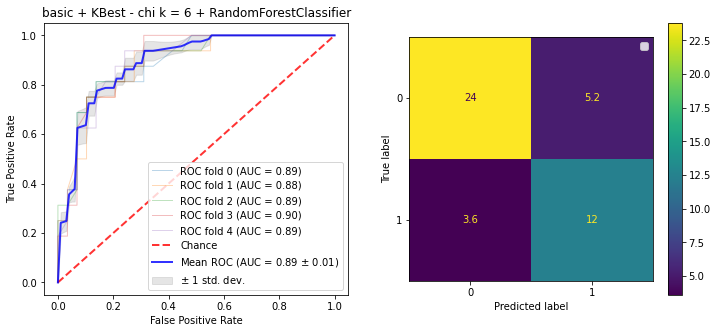

KBest - chi k = 10 + RandomForestClassifier
\AUC train k-flod: 0.924 | AUC test: 0.881


<Figure size 432x288 with 0 Axes>

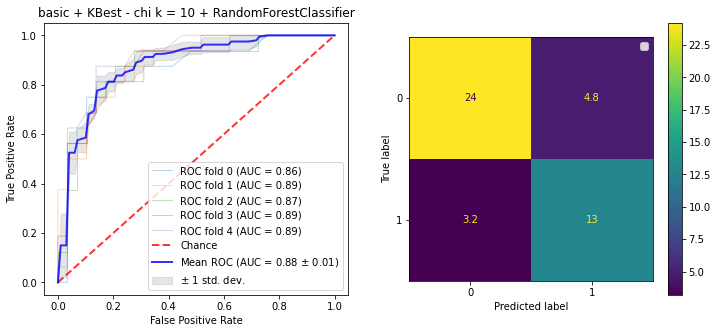

RandomForestClassifier
\AUC train k-flod: 0.921 | AUC test: 0.881


<Figure size 432x288 with 0 Axes>

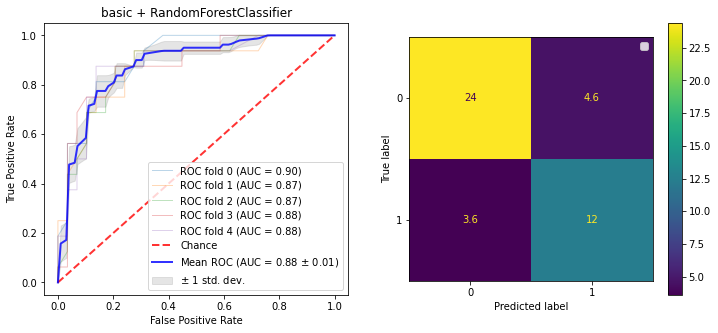

In [76]:
build_metrics(DATASETS[0])

### 2) Sin outlier

KBest - chi k = 10 + Normalizer + RandomForestClassifier
\AUC train k-flod: 0.892 | AUC test: 0.886


<Figure size 432x288 with 0 Axes>

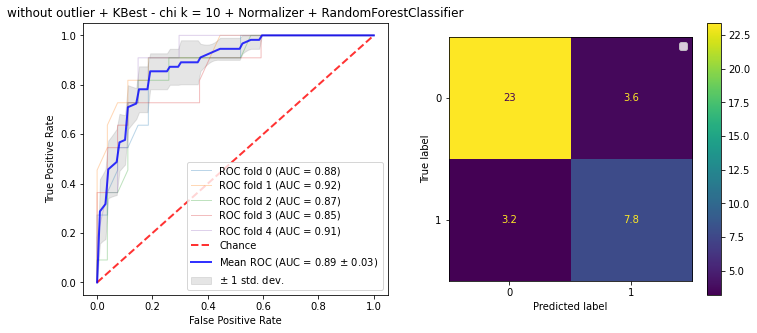

RFE k = 10 + Normalizer + GradientBoostingClassifier
\AUC train k-flod: 0.866 | AUC test: 0.912


<Figure size 432x288 with 0 Axes>

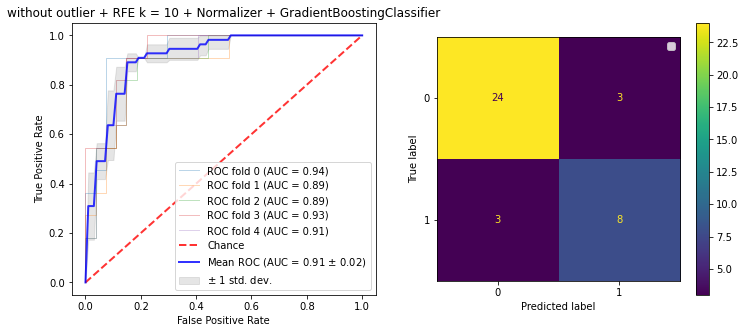

Normalizer + GradientBoostingClassifier
\AUC train k-flod: 0.876 | AUC test: 0.898


<Figure size 432x288 with 0 Axes>

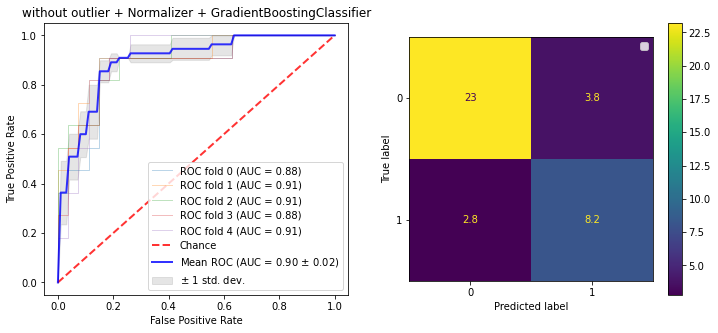

In [77]:
build_metrics(DATASETS[1])

### 3) Datos balanceados (SMOTE)

RandomForestClassifier
\AUC train k-flod: 0.940 | AUC test: 0.954


<Figure size 432x288 with 0 Axes>

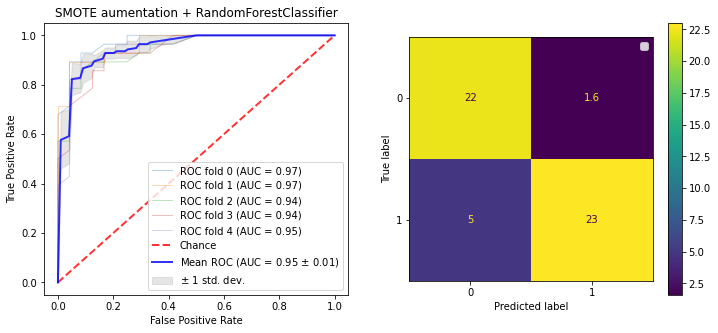

KBest - chi k = 10 + RandomForestClassifier
\AUC train k-flod: 0.940 | AUC test: 0.953


<Figure size 432x288 with 0 Axes>

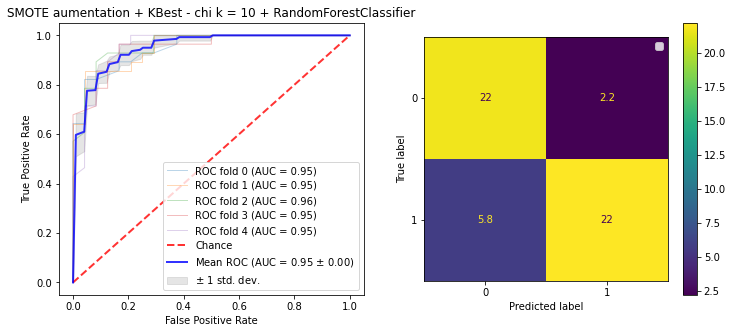

StandardScaler + RandomForestClassifier
\AUC train k-flod: 0.939 | AUC test: 0.940


<Figure size 432x288 with 0 Axes>

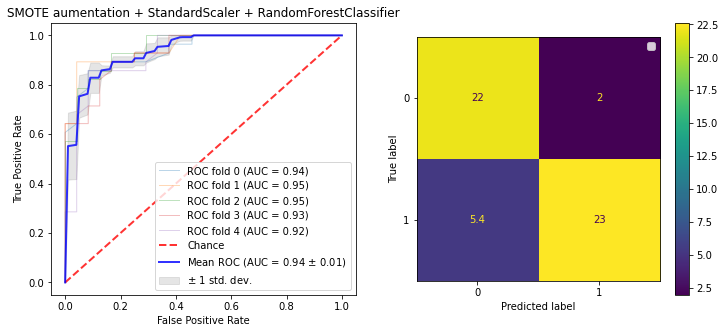

In [78]:
build_metrics(DATASETS[2])

Se generan muy buenos resultados para las distintas combinaciones, sin embargo los mejores se obtienen para el dataset con aumentación de datos y haciendo uso de un RandomForest como clasificador que tanto en entrenamiento como en test es superior a un 94% AUC. Como haciendo uso de normalizaciones o sin ellas se llegan a resultados similares para el procesamiento de ajuste únicamente se va a escoger un RandomForest simple junto al conjunto de datos aumentado.

## Hyperparameter optimization

El proceso de optimización consiste en probar diferentes combinaciones de los hiper-parámetros mediante una búsqueda aleatoria, la función *RandomizedSearchCV* implementa este comportamiento. Además se utiliza otra vez un proceso k-flod estratificado con k = 5.

In [90]:
from sklearn.model_selection import StratifiedKFold
ds = DATASETS[2]
X_train, X_test, y_train, y_test = ds.split()

# Número de árboles
n_estimators=list(range(100,1000,100))
# Maxima profundidad
max_depth = list(range(4,13,4))
# El número mínimo de muestras necesarias para estar en un nodo hoja
min_samples_leaf=[1,2,5,7]
# Número mínimo de muestras necesarias para dividir un nodo interno
min_samples_split=list(range(2,9,2))
# Número de características a considerar en cada división
max_features=['auto','sqrt']


param_grid = {"n_estimators":n_estimators,
              "max_depth":max_depth,
              "min_samples_split":min_samples_split,
              "min_samples_leaf":min_samples_leaf,
              "max_features":max_features}

skf = StratifiedKFold(n_splits=5, shuffle = True, random_state = 0)

model = RandomizedSearchCV(estimator = RandomForestClassifier(), param_distributions = param_grid,
                           cv = skf.split(X_train,y_train))

rf = model.fit(X_train,y_train)
print(rf.best_params_)

{'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 8}


El mejor clasficador que encontro el método fue el siguiente:

* Número de árboles = 200
* Profundidad = 8
* Muestras en un nodo hoja = 1
* Muestras para la división = 2
* Número de características a considerar en cada división = método auto

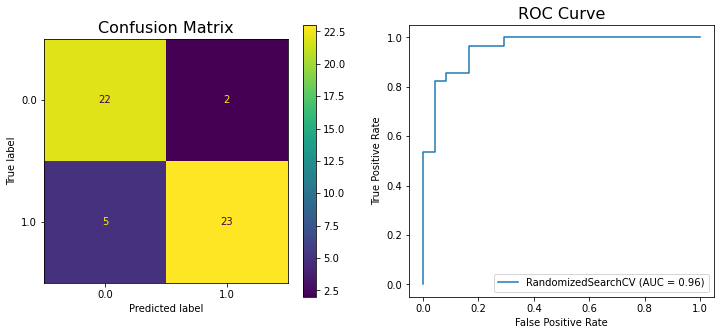

In [91]:
fig, ax = plt.subplots(1,2,figsize=(12,5))
plot_confusion_matrix(model,X_test,y_test, ax=ax[0])
ax[0].set_title("Confusion Matrix",fontsize=16)
ax[0].set_xticks([0,1], ["Heart Not Failed","Heart Fail"])
ax[0].set_yticks([0,1], ["Heart Not Failed","Heart Fail"])
ax[0].grid(False)

plot_roc_curve(model,X_test,y_test,ax=ax[1])
ax[1].set_title("ROC Curve",fontsize=16)
plt.show()

## Conclusión



Como se planteó cuando observamos la representación del conjunto de datos mediante T-SNE, los métodos basados en ensemble, en este caso usando un RandomForest, son con los que hemos logrado un mejor rendimiento con respecto una métrica basada en la curva ROC y la relación de falsos positivos y negativos. Hubiera sido interesante plantear un ensemble basado en redes neuronales para sacar comparativas, dado que la solución del problema utilizando Deep Learning no ha logrado sobreponerse a algunos métodos *clásicos* que se han empleado. Finalmente, se ha llegado a obtener un modelo que logra clasificar muy bien las muestras con una precisión de un 96% AUC y una matriz de confusión adecuada.

Se ha comprobado también que utilizar validación cruzada con k-fold para problemas con pocos datos puede llegar a ser beneficioso para los clasificadores que estemos usando, asimismo realizar un análisis exploratorio de los datos es esencial para poder extrapolar relaciones entre ellos que nos ayuden a realizar mejores predicciones. Por último, aunque dentro de la literatura el algoritmo SMOTE es muy utilizado para la aumentación de datos sería interesante aplicar otras técnicas de aprendizaje generativa para este problema como podrían ser el uso de [GANs](https://www.nature.com/articles/s41598-019-52737-x) para la aumentación de datos.


## Referencias

* [Sklearn](https://scikit-learn.org/)
* [Repositorio con los datos](https://www.kaggle.com/andrewmvd/heart-failure-clinical-data)
* [Apuntes de clases](https://ncvt-aep.ulpgc.es/cv/ulpgctp21/course/view.php?id=118)

# Anexo

## Lazy Cls

In [25]:
from lazypredict.Supervised import LazyClassifier

In [45]:
def train_lazy_models(X_train, X_test, y_train, y_test):
    clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
    models, _ = clf.fit(X_train, X_test, y_train, y_test)
    return models

In [46]:
lazy_models = {
    ds.name : train_lazy_models(*ds.split())
    for ds in DATASETS
}

100%|██████████| 29/29 [00:00<00:00, 56.43it/s]


[LightGBM] [Info] Number of positive: 83, number of negative: 171
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000060 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 317
[LightGBM] [Info] Number of data points in the train set: 254, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.326772 -> initscore=-0.722823
[LightGBM] [Info] Start training from score -0.722823
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

100%|██████████| 29/29 [00:00<00:00, 57.12it/s]


[LightGBM] [Info] Number of positive: 59, number of negative: 151
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000058 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 271
[LightGBM] [Info] Number of data points in the train set: 210, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.280952 -> initscore=-0.939742
[LightGBM] [Info] Start training from score -0.939742
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

100%|██████████| 29/29 [00:00<00:00, 48.98it/s]

[LightGBM] [Info] Number of positive: 140, number of negative: 150
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000046 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 496
[LightGBM] [Info] Number of data points in the train set: 290, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.482759 -> initscore=-0.068993
[LightGBM] [Info] Start training from score -0.068993
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

In [47]:
print(lazy_models["basic"])

                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score   
Model                                                                           
XGBClassifier                      0.84               0.84     0.84      0.85  \
GaussianNB                         0.87               0.84     0.84      0.87   
SVC                                0.87               0.84     0.84      0.87   
RandomForestClassifier             0.87               0.84     0.84      0.87   
NuSVC                              0.87               0.84     0.84      0.87   
QuadraticDiscriminantAnalysis      0.84               0.80     0.80      0.84   
NearestCentroid                    0.78               0.80     0.80      0.79   
AdaBoostClassifier                 0.82               0.78     0.78      0.82   
LGBMClassifier                     0.82               0.78     0.78      0.82   
CalibratedClassifierCV             0.84               0.78     0.78      0.84   
SGDClassifier               

In [48]:
print(lazy_models["without outlier"])

                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score   
Model                                                                           
XGBClassifier                      0.79               0.79     0.79      0.79  \
SGDClassifier                      0.76               0.76     0.76      0.76   
PassiveAggressiveClassifier        0.76               0.76     0.76      0.76   
LGBMClassifier                     0.76               0.76     0.76      0.76   
LinearDiscriminantAnalysis         0.76               0.76     0.76      0.76   
RandomForestClassifier             0.76               0.76     0.76      0.76   
NearestCentroid                    0.74               0.74     0.74      0.74   
DecisionTreeClassifier             0.74               0.73     0.73      0.74   
RidgeClassifier                    0.74               0.73     0.73      0.73   
LogisticRegression                 0.74               0.73     0.73      0.73   
LinearSVC                   

In [49]:
print(lazy_models["SMOTE aumentation"])

                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score   
Model                                                                           
XGBClassifier                      0.90               0.90     0.90      0.90  \
ExtraTreeClassifier                0.87               0.86     0.86      0.87   
ExtraTreesClassifier               0.87               0.86     0.86      0.87   
RandomForestClassifier             0.87               0.86     0.86      0.86   
LGBMClassifier                     0.85               0.85     0.85      0.85   
SGDClassifier                      0.85               0.83     0.83      0.84   
BaggingClassifier                  0.83               0.82     0.82      0.83   
RidgeClassifierCV                  0.83               0.82     0.82      0.83   
RidgeClassifier                    0.83               0.82     0.82      0.83   
LinearDiscriminantAnalysis         0.83               0.82     0.82      0.83   
NearestCentroid             

## Optuna